 ### Multinomial NB Classifer to Predict Categories

1. train test split or use a StratifiedKFold

*train set*
2. clean your text and then vectorize it (using tfidf or count vectorizer)
3. then use truncated SVD OR LDA to reduce dimensions on your sparse matrix generated after fit_transforming with your vectorizer. here, you want to fit_transform one more time
4. fit a classification model (multinomial nb classifier if you have more than binary classifiers) this can be done in a pipeline and gridsearched if i choose to. if you do a pipeline then it's just pipeline.predict or pipeline.score

*test set*
5. if you don't do a pipeline, then vectorize it by only doing .transform
6. then dimension reduction .transform
7. then predict/score 

*pretend you have a new article*
8. test to see if the classification model worked
9. How:
    a. query the wikipedia API (which we did in part I)
    b. grab the text (optional: clean the text <-- YES, I will do this)
    c. then pipe it into the predict/score in # 7 above and then it should output a category

In [5]:
pwd

'/home/jovyan/ipynb'

In [6]:
from os import chdir
chdir('/home/jovyan/')

In [7]:
import library.db_helper as db
import library.functions as fy

In [109]:
import pandas as pd, seaborn as sns, numpy as np, matplotlib.pyplot as plt
%matplotlib inline

#### Explore my Page Count per Category

In [10]:
query = '''
SELECT * 
FROM category_page;
'''
cat_page_df = db.query_to_dataframe(query)
cat_page_df.shape

(2787, 2)

In [11]:
cat_page_df.sample(5)

,category_cid,page_pid
838,56,318439
199,14,45641381
55,11,30708494
578,3,574759
2778,10,5192200


In [28]:
from collections import Counter

In [41]:
page_counts_per_cat = cat_page_df.groupby('category_cid').size()

In [69]:
page_count_per_cat_df = pd.DataFrame(page_counts_per_cat).reset_index()\
                                                        .rename(columns={0:"pagecount", 'category_cid':'cid'})

In [70]:
page_count_per_cat_df.sample(5)

,cid,pagecount
26,26,12
56,56,35
48,48,10
27,27,23
17,17,6


In [47]:
query = '''
SELECT * 
FROM category'''
category_df = db.query_to_dataframe(query)

In [77]:
cid_name_pgcount_df = category_df.merge(page_count_per_cat_df, on='cid', how='left')
cid_name_pgcount_df.sort_values(by='pagecount', ascending=False, inplace=True)

,cid,name,pagecount
31,11,business software,298
0,43,machine learning,198
33,5,business simulation games,189
47,32,java enterprise platform,170
54,50,project management software,134
34,6,business software companies,133
2,3,artificial neural networks,128
63,10,business software stubs,113
38,14,collaborative software,105
8,16,data mining and machine learning software,87


In [106]:
cid_name_pgcount_df['pagecount'].mean()

43.546875

In [107]:
cid_name_pgcount_df['pagecount'].min()

1

In [108]:
cid_name_pgcount_df['pagecount'].max()

298

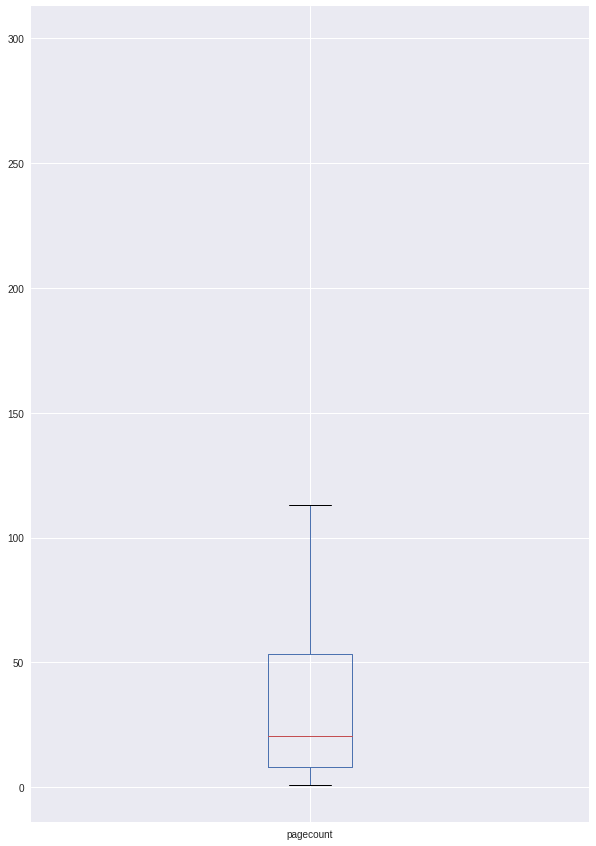

In [118]:
plt.figure(figsize=(10,15))
cid_name_pgcount_df.boxplot(column='pagecount')
plt.show()

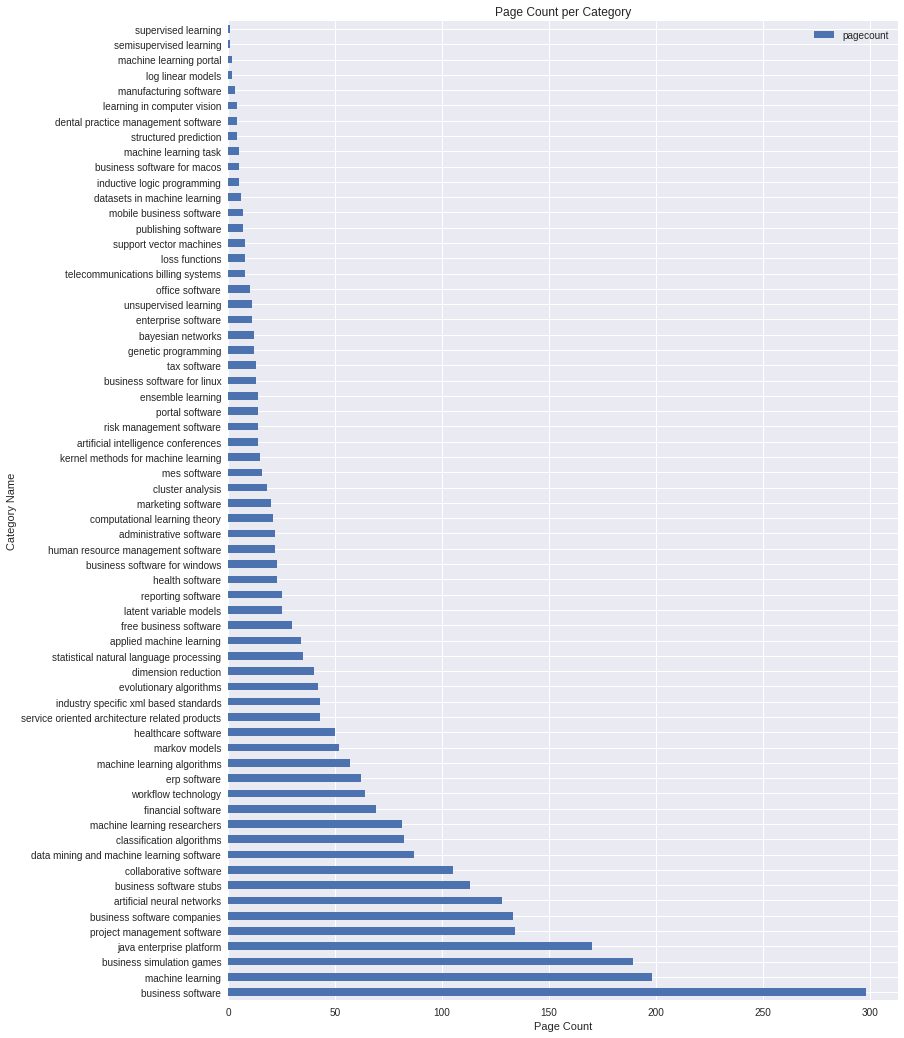

In [84]:
# display a plot to visualize how many pagecounts there are per category (across all 64 categories)
cid_name_pgcount_df[['name', 'pagecount']].plot(x='name', y='pagecount', kind='barh', figsize=(12,18))
plt.xlabel('Page Count')
plt.ylabel('Category Name')
plt.title('Page Count per Category')
plt.show()

Since I grabbed 64 categories, I will run a Multinomial NB classifier model. However, there is an uneven distribution in articles per category as evidenced by the horizontal barplot above. This is a result of my initial data collection process whereby I was unable to address heirarchal issues pertaining to sub-categories. As a result of articles skewing toward the two categories (i) business software and (ii) machine learning, my classification model will likely predict those two categories with higher probas than any of the other 62 categories. 

#### Setup a train/test/split - establish my X and y

In [9]:
query = '''
SELECT text
FROM page;
'''
X = db.query_to_dataframe(query)
X.shape

(2787, 1)

In [89]:
query = '''
SELECT category_cid
FROM category_page
'''
y = db.query_to_dataframe(query)
y.shape

(2787, 1)

In [94]:
y_vec = (np.array(y).ravel()).shape

Because I have 64 categories that are skewed, I have opted to use StratifiedKFold to split my data instead of a traditional train/test/split on my data. Based on the distribution above, I am opting to do more splits than 

#### Train and fit a model using GridSearchCV

In [99]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer 
from sklearn.decomposition import TruncatedSVD
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

from sklearn.pipeline import Pipeline

In [100]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import train_test_split, cross_val_score, ShuffleSplit, StratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report

In [103]:
multinom_pipeline = Pipeline([
    ('countvec', CountVectorizer(stop_words='english')),
    ('svd', TruncatedSVD()),
    ('clfr', MultinomialNB()),
])

In [104]:
mnnb_params = {
    'countvec__ngram_range':[(1,2), (1,3)],
    'countvec__min_df':[1, 2, 3],
    'svd__n_components':[300, 400, 500],
    'clfr__alpha': np.linspace(0.01, 0.99, 5)
}

In [105]:
mnnb_gs = GridSearchCV(multinom_pipeline, param_grid=mnnb_params, cv=3)

In [8]:
pca_article = fy.beautify_html_article('Principal_component_analysis')

In [55]:
# the PCA article does not fall into 

pca_clean_article = fy.text_cleaner(pca_article)
pca_clean_article

'pca of a multivariate gaussian distribution centered at   with a standard deviation of  in roughly the     direction and of  in the orthogonal direction the vectors shown are the eigenvectors of the covariance matrix scaled by the square root of the corresponding eigenvalue and shifted so their tails are at the mean principal component analysis pca is a statistical procedure that uses an orthogonal transformation to convert a set of observations of possibly correlated variables into a set of values of linearly uncorrelated variables called principal components or sometimes principal modes of variation the number of principal components is less than or equal to the smaller of the number of original variables or the number of observations this transformation is defined in such a way that the first principal component has the largest possible variance that is accounts for as much of the variability in the data as possible and each succeeding component in turn has the highest variance pos